In [1]:
from src.dm import DataModule

dm = DataModule(val_trans={'Resize': {'width': 224, 'height': 224}})
dm.setup()

/home/sensio/miniconda3/lib/python3.8/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [2]:
import glob

models = glob.glob('*fold*.ckpt')
models

['Unet-resnet18-fold3-val_iou=0.8695.ckpt',
 'Unet-resnet18-fold1-val_iou=0.8400.ckpt',
 'Unet-resnet18-fold4-val_iou=0.8581.ckpt',
 'Unet-resnet18-fold2-val_iou=0.8695.ckpt',
 'Unet-resnet18-fold5-val_iou=0.8574.ckpt']

In [3]:
import nibabel as nib
from tqdm import tqdm
import torch
import random
from src.models import SMP

ious = []
for model_name in models:
    model = SMP.load_from_checkpoint(model_name)
    model.eval()
    model.cuda()
    _ious = []
    with torch.no_grad():
        for batch in tqdm(dm.val_dataloader()):
            x, y = batch
            x, y = x.cuda(), y.cuda()
            y_hat = model(x)
            _ious.append(model.iou(y_hat, y).item())
            break
    ious.append(np.mean(_ious))

  0%|          | 0/31 [00:01<?, ?it/s]


In [4]:
ious

[0.9029792547225952,
 0.8753491044044495,
 0.8636962175369263,
 0.9171707630157471,
 0.9101019501686096]

In [5]:
np.mean(ious), np.std(ious)

(0.8938594579696655, 0.020701982760651293)

In [6]:
ious, preds = [], []
for model_name in models:
    model = SMP.load_from_checkpoint(model_name)
    model.eval()
    model.cuda()
    with torch.no_grad():
        for batch in tqdm(dm.val_dataloader()):
            x, y = batch
            x, y = x.cuda(), y.cuda()
            y_hat = model(x)
            break
    preds.append(y_hat)      
preds = torch.stack(preds)

  0%|          | 0/31 [00:00<?, ?it/s]


In [7]:
preds.shape

torch.Size([5, 32, 4, 224, 224])

In [8]:
mean_preds = preds.mean(0)
mean_preds.shape

torch.Size([32, 4, 224, 224])

In [9]:
model.iou(y_hat, y).item()

0.9101019501686096

In [10]:
import ttach as tta

ious, preds = [], []
for model_name in models:
    model = SMP.load_from_checkpoint(model_name)
    tta_model = tta.SegmentationTTAWrapper(model, tta.aliases.d4_transform(), merge_mode='mean')
    tta_model.eval()
    tta_model.cuda()
    with torch.no_grad():
        for batch in tqdm(dm.val_dataloader()):
            x, y = batch
            x, y = x.cuda(), y.cuda()
            y_hat = tta_model(x)
            break
    preds.append(y_hat)      
preds = torch.stack(preds)
mean_preds = preds.mean(0)
model.iou(y_hat, y).item()

  0%|          | 0/31 [00:01<?, ?it/s]


0.9178391098976135

In [14]:
path = 'data/MnM-2/validation'
patients = os.listdir(path)
len(patients)

40

In [15]:
dest = 'preds'
#!rm -rf {dest}
os.makedirs(dest, exist_ok=True)

In [16]:
def compute_preds(models, patient, file):
    img = nib.load(f'{path}/{patient}/{patient}_{file}.nii.gz')
    img_data = img.get_fdata() / max_val[file]
    resized = resize(image=img_data)['image']
    img_t = torch.from_numpy(resized).float().permute(2,0,1).unsqueeze(1)
    preds = []
    for model_name in models:
        model = SMP.load_from_checkpoint(model_name)
        tta_model = tta.SegmentationTTAWrapper(model, tta.aliases.d4_transform(), merge_mode='mean')
        tta_model.eval()
        tta_model.cuda()
        with torch.no_grad():
            output = tta_model(img_t.cuda())
        preds.append(output)
    preds = torch.stack(preds)
    preds = preds.mean(0)
    masks = torch.argmax(output, axis=1).float().cpu().permute(1,2,0).numpy()
    masks_resized = np.rint(A.Resize(*img.shape[:2])(image=masks)['image'])
    nib.save(nib.Nifti1Image(masks_resized, img.affine), f'{dest}/{patient}/{patient}_{file}_pred.nii.gz')  

In [17]:
import nibabel as nib
from tqdm import tqdm
import albumentations as A
import torch

max_val = {
    'LA_ED': 4104.,
    'LA_ES': 7875.,
    'SA_ED': 11510.0,
    'SA_ES': 9182.0
}
resize = A.Resize(224, 224)
for patient in tqdm(patients):
    os.makedirs(f'{dest}/{patient}', exist_ok=True)
    compute_preds(models, patient, 'LA_ED')
    compute_preds(models, patient, 'LA_ES')
    compute_preds(models, patient, 'SA_ED')
    compute_preds(models, patient, 'SA_ES')
    break

  0%|          | 0/40 [00:15<?, ?it/s]


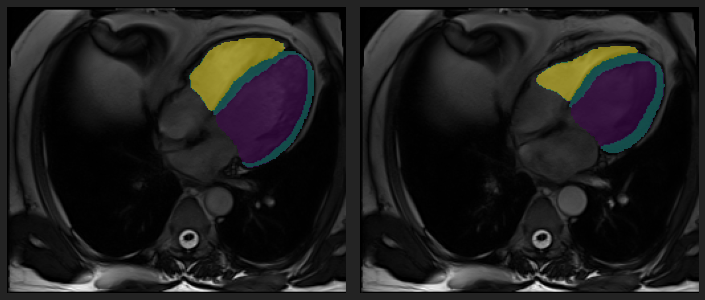

In [30]:
import matplotlib.pyplot as plt
import random

ix = 0#random.randint(0, len(patients))
sample = patients[ix]
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(1, 2, 1)
image_path = f'{path}/{sample}/{sample}_LA_ED.nii.gz'
img = nib.load(image_path).get_fdata()
ax.imshow(img,cmap='gray')
image_path = f'{dest}/{sample}/{sample}_LA_ED_pred.nii.gz'
mask = nib.load(image_path).get_fdata()
ax.imshow(img, cmap='gray')
mask[mask == 0] = np.nan
ax.imshow(mask, alpha=0.5)
ax.axis('off')
ax = plt.subplot(1, 2, 2)
image_path = f'{path}/{sample}/{sample}_LA_ES.nii.gz'
img = nib.load(image_path).get_fdata()
ax.imshow(img, cmap='gray')
image_path = f'{dest}/{sample}/{sample}_LA_ES_pred.nii.gz'
mask = nib.load(image_path).get_fdata()
mask[mask == 0] = np.nan
ax.imshow(mask, alpha=0.5)
ax.axis('off')
plt.tight_layout()
plt.show()

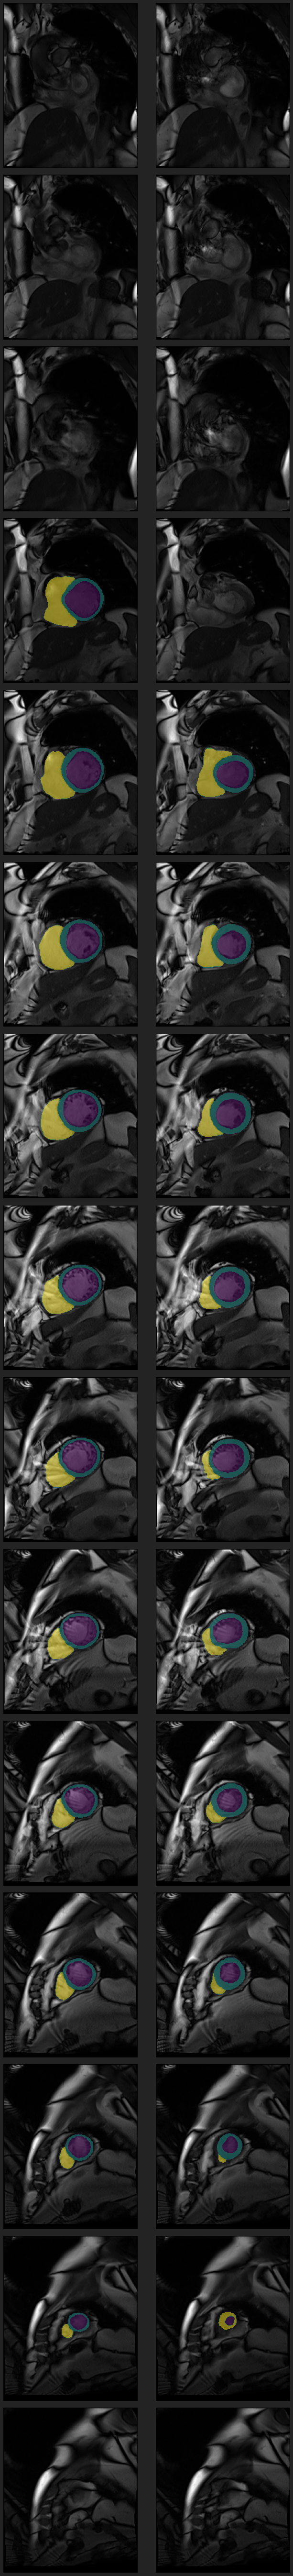

In [31]:
ed_img = nib.load(f'{path}/{sample}/{sample}_SA_ED.nii.gz').get_fdata()
channels = ed_img.shape[-1]
ed_pred = nib.load(f'{dest}/{sample}/{sample}_SA_ED_pred.nii.gz').get_fdata()
es_img = nib.load(f'{path}/{sample}/{sample}_SA_ES.nii.gz').get_fdata()
es_pred = nib.load(f'{dest}/{sample}/{sample}_SA_ES_pred.nii.gz').get_fdata()
fig = plt.figure(figsize=(10, channels*5))
for c in range(channels):
    ax = plt.subplot(channels, 2, 2*c + 1)
    ax.imshow(ed_img[...,c],cmap='gray')
    mask = ed_pred[...,c]
    mask[mask == 0] = np.nan
    ax.imshow(mask, alpha=0.5)
    ax.axis('off')
    ax = plt.subplot(channels, 2, 2*c + 2)
    ax.imshow(es_img[...,c],cmap='gray')
    mask = es_pred[...,c]
    mask[mask == 0] = np.nan
    ax.imshow(mask, alpha=0.5)
    ax.axis('off')
plt.tight_layout()
plt.show()